In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Set up plotting  
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Import standard packages
import numpy as np
import pandas as pd
from scipy.stats import uniform

# Import misc tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import verification tools
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score

# Import preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# Change from previous notebooks to drop the single case of 'UM' at the 
# beginning -- inclusion prevents use of 'stratify'.)
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM',' M', 
                       'AF','BF','CF','DF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

#df = df.loc[df.days<1095]

In [3]:
# Only working with the 94% under 80k.
#df = df.loc[df.bond_amount<=80000]
#print(df.info())

# Separate out the two datasets, misdemeanor (primary) and felony.
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M',na=False)].reset_index(
    drop=True).rename(index=str, columns={'offense_class_ M':'offense_class_M'})

# Change race, gender, facility, and detainer to category type and verify.
misdemeanor_df.race = misdemeanor_df.race.astype('category')
misdemeanor_df.gender = misdemeanor_df.gender.astype('category')
misdemeanor_df.facility = misdemeanor_df.facility.astype('category')
misdemeanor_df.detainer = misdemeanor_df.detainer.astype('category')
misdemeanor_df.offense_class = misdemeanor_df.offense_class.astype('category')

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

# Check that everything worked.  There should be 0 null values.
misdemeanor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9663 entries, 0 to 9662
Data columns (total 13 columns):
download_date            9663 non-null datetime64[ns]
identifier               9663 non-null object
latest_admission_date    9663 non-null datetime64[ns]
race                     9663 non-null category
gender                   9663 non-null category
age                      9663 non-null int64
bond_amount              9663 non-null int64
offense                  9663 non-null object
facility                 9663 non-null category
detainer                 9663 non-null category
offense_class            9663 non-null category
days                     9663 non-null int64
counts                   9663 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4), object(2)
memory usage: 1.0+ MB


In [4]:
# Utility functions to report scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print('')
            print('Model rank:', i)
            print('Mean test score: %0.2f (+/- %0.2f)' %
                  (results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print('Parameters: {0}'.format(results['params'][candidate]))
            
def scores(clf,X_test,y_test,cv=5):
    score = cross_val_score(clf, X_test, y_test, cv=5) 
    print('Accuracy, gender (test): %0.4f (+/- %0.2f)' % (score.mean(), score.std() * 2))
    print('F1, gender (test): %0.2f' % f1_score(y_test,clf.predict(X_test)))
    print('Recall, gender (test): %0.2f' % recall_score(y_test,clf.predict(X_test)))
    print('Precision, gender (test): %0.2f' % precision_score(y_test,clf.predict(X_test)))
    print('AUROC, gender (test): %0.2f' % roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))

### Gender categorization:
1. Define data and target from the pre-enactment dataframe
2. Split, preprocess, and fit
3. Test the accuracy on pre-enactment test data
4. See what happens with the post-enactment data

One problem that has to be addressed is the imbalance of male/female samples.  Here's the original percentage:

In [5]:
ratio = len(mis_pre_df.loc[mis_pre_df.gender=='M'])/len(mis_pre_df.gender)
print('Original male/female split: %0.4f' % ratio)

Original male/female split: 0.8272


And here's how logistic regression first handles the data.  It guesses "M" and gets it right frequently enough that it calls it quits.

In [6]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race']]
X = pd.get_dummies(X,columns=['offense_class','race'],drop_first=True)
y = mis_pre_df.gender.ravel()

# Make y traditional binary so recall can be accessed
gender = {'M': 1,'F': 0}
y = [gender[item] for item in y]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

# Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(X_train,y_train)

# Print the accuracy
scores(clf,X_test,y_test,cv=5)

Accuracy, gender (test): 0.8269 (+/- 0.00)
F1, gender (test): 0.91
Recall, gender (test): 1.00
Precision, gender (test): 0.83
AUROC, gender (test): 0.58


Time to upsample the "F" samples - X_train, y_train ONLY, retain X_test, y_test.  Data to be used on logistic regression, KNN, and random forest models for gender models.

In [7]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race']]
X = pd.get_dummies(X,columns=['offense_class','race'],drop_first=True,dtype='float')
X = X.astype('float')
y = mis_pre_df.gender.ravel()

# Make y traditional binary so recall can be accessed
gender = {'M': 1.0,'F': 0.0}
y = [gender[item] for item in y]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

# Merge the dfs back together to do the resampling and then pull back apart
to_rebalance_df = X_train.copy()
to_rebalance_df['gender'] = y_train.copy()

rebalance_F = to_rebalance_df.loc[to_rebalance_df.gender==0]
rebalance_M = to_rebalance_df.loc[to_rebalance_df.gender==1]

samples = len(rebalance_M)

F_upsampled = resample(rebalance_F,replace=True,n_samples=samples)

balanced_df = pd.concat([F_upsampled,rebalance_M])

X_train = balanced_df.drop('gender',axis=1)
y_train = balanced_df.gender.ravel()

First pass at balanced logistic regression.  

In [8]:
# Rescale the data
scaler = MinMaxScaler()

# Classifier
lr = LogisticRegression(solver='liblinear',random_state=3)

pl = Pipeline([
        ('scaler', scaler),
        ('clf', lr)
    ])

pl = pl.fit(X_train,y_train)

# Print the accuracy
scores(pl,X_test,y_test,cv=5)

Accuracy, gender (test): 0.8269 (+/- 0.00)
F1, gender (test): 0.68
Recall, gender (test): 0.55
Precision, gender (test): 0.89
AUROC, gender (test): 0.64


After fixing my rebalancing issue, the previous model now appears to be guessing like the unbalanced model, but recall is no longer 1.0.  Importantly, AUROC has increased.  Tuning might stop the guessing?

In [9]:
# Create regularization penalty space
penalty = ['l1','l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=100)
#C = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Run randomized search with train scores turned on to stop pink deprecation warnings
n_iter_search = 20
random_search = RandomizedSearchCV(lr, hyperparameters, n_iter=n_iter_search, cv=5, return_train_score=False)

random_search.fit(X_train, y_train)

print('RandomizedSearchCV for', n_iter_search, 'candidates parameter settings:')
report(random_search.cv_results_)

lr_to_beat = random_search.best_score_
best_lr = random_search.best_estimator_
best_lr.fit(X_train,y_train)

RandomizedSearchCV for 20 candidates parameter settings:

Model rank: 1
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 3.0317426848513684, 'penalty': 'l1'}

Model rank: 2
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 3.481809649686274, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 65.14008474680341, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 97.45338013579766, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 15.795821145310828, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 94.17360682928076, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 83.86530035917849, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 23.178398865542615, 'penalty': 'l1'}

Model rank: 3
Mean test score: 0.61 (+/- 0.01)
Parameters: {'C': 72.5717474798121, 'penalty': 'l1'}


LogisticRegression(C=3.0317426848513684, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Tuned logistic regression below.  Hyperparameters don't improve the model, and neither AUROC nor recall improve.  LR isn't going to to provide a good model.

(Regarding hyperparameter tuning - Tuning mean test scores don't match the test scores on the training data because the upsampled data is used for tuning.  It bleeds into the internal RandomizedSearchCV test data.)

In [10]:
pl_tuned = Pipeline([
        ('scaler', scaler),
        ('clf', best_lr)
    ])

pl_tuned.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=3.0317426848513684, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [11]:
# Print the accuracy of the tuned LR
scores(pl_tuned,X_test,y_test,cv=5)

Accuracy, gender (test): 0.8269 (+/- 0.00)
F1, gender (test): 0.69
Recall, gender (test): 0.56
Precision, gender (test): 0.89
AUROC, gender (test): 0.65


In [12]:
# Verifying that it isn't really predicting just "M" anymore
n = pl_tuned.predict(X_test)
n

array([1., 0., 0., ..., 1., 1., 0.])

Trying out KNN for k=1...39 and plotting the cross-validated accuracy.  After a certain point, I think it reverts to guessing, too.

Best: [(4, 0.0041100666782651896), (3, 0.008089729803327672), (5, 0.06299244984286334), (6, 0.07602914423933993), (7, 0.11359939164084454)]


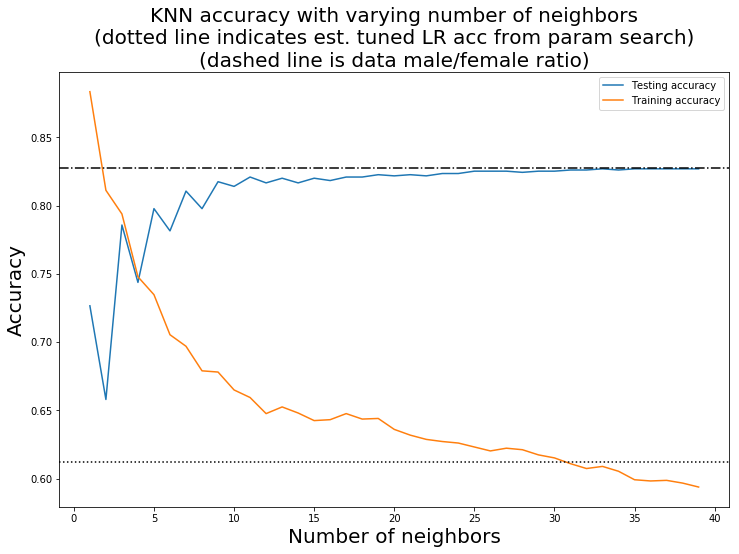

In [13]:
# Set up variables for testing
neighbors = np.arange(1,40,1) 
train_accuracy = np.zeros(len(neighbors))
test_accuracy = np.zeros(len(neighbors))
best_acc = []
best_neighbor = []

for i, k in enumerate(neighbors):
    
    # Rescale the data
    scaler = Normalizer()
    # Call classifier with neighbor choices
    clf = KNeighborsClassifier(n_neighbors=k)
    # Set up the pipeline
    pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

    #Fit the model
    pl.fit(X_train,y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = cross_val_score(pl, X_train, y_train, cv=5).mean()

    #Compute accuracy on the test set
    test_accuracy[i] = cross_val_score(pl, X_test, y_test, cv=5).mean()
    
    if (ratio>=test_accuracy[i]>=lr_to_beat):
        best_neighbor.append(k)
        best_acc.append(abs(test_accuracy[i]-train_accuracy[i]))
        
min_list = sorted(zip(best_neighbor,best_acc), key=lambda t: t[1])[0:5]
print('Best:', min_list)
    
_ = plt.figure(figsize=(12,8))
_ = plt.title('KNN accuracy with varying number of neighbors'+
              '\n(dotted line indicates est. tuned LR acc from param search)'+
              '\n(dashed line is data male/female ratio)', fontsize=20)
_ = plt.plot(neighbors, test_accuracy, label='Testing accuracy')
_ = plt.plot(neighbors, train_accuracy, label='Training accuracy')
_ = plt.legend()
_ = plt.xlabel('Number of neighbors', fontsize=20)
_ = plt.ylabel('Accuracy', fontsize=20)
_ = plt.axhline(lr_to_beat, color='black', linestyle=':', label='LogReg accuracy')
_ = plt.axhline(ratio, color='black', linestyle='-.', label='M/F ratio')

In [14]:
# Build the model with the best neighbors from test above and print testing cv acc for each
for k, acc in min_list:
    # Rescale the data
    scaler = Normalizer()

    # Classifier
    clf = KNeighborsClassifier(n_neighbors=k)

    pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

    pl.fit(X_train,y_train)

    # Print the accuracy
    print('Tests for',k,'neighbors:')
    scores(pl,X_test,y_test,cv=5)
    print('')

Tests for 4 neighbors:
Accuracy, gender (test): 0.7438 (+/- 0.02)
F1, gender (test): 0.70
Recall, gender (test): 0.59
Precision, gender (test): 0.84
AUROC, gender (test): 0.54

Tests for 3 neighbors:
Accuracy, gender (test): 0.7858 (+/- 0.02)
F1, gender (test): 0.77
Recall, gender (test): 0.71
Precision, gender (test): 0.84
AUROC, gender (test): 0.54

Tests for 5 neighbors:
Accuracy, gender (test): 0.7978 (+/- 0.02)
F1, gender (test): 0.71
Recall, gender (test): 0.61
Precision, gender (test): 0.84
AUROC, gender (test): 0.54

Tests for 6 neighbors:
Accuracy, gender (test): 0.7815 (+/- 0.02)
F1, gender (test): 0.64
Recall, gender (test): 0.52
Precision, gender (test): 0.85
AUROC, gender (test): 0.54

Tests for 7 neighbors:
Accuracy, gender (test): 0.8106 (+/- 0.02)
F1, gender (test): 0.68
Recall, gender (test): 0.57
Precision, gender (test): 0.84
AUROC, gender (test): 0.56



KNN is interesting here.  I wanted to at least try it because I felt there was potential, but it's a mess.  The AUROC and f1 scores are worse than LR

Moving on to random forests.

Accuracy, gender (test): 0.7978 (+/- 0.02)
F1, gender (test): 0.86
Recall, gender (test): 0.89
Precision, gender (test): 0.84
AUROC, gender (test): 0.61


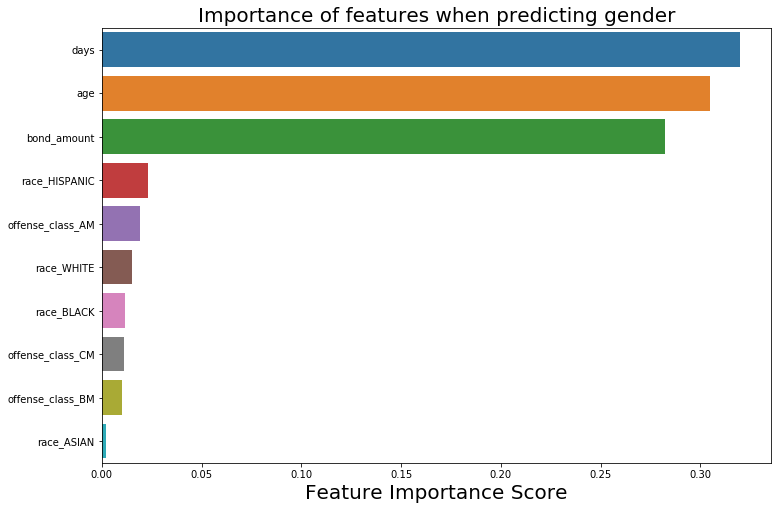

In [15]:
# Classifier
rf = RandomForestClassifier(n_estimators=100,random_state=3)

rf.fit(X_train,y_train)

scores(rf,X_test,y_test,cv=5)

feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel('Feature Importance Score', fontsize=20)
_ = plt.title('Importance of features when predicting gender', fontsize=20)

As somewhat expected, the cross_val_score of the random forest is higher than the logistic regression, increasing from lower 60s to over 75% out of the box.  Random forest will be tuned in further steps.

Here's the code to search for the best hyperparameters.  The search claims that a tuned random forest will reach nearly 90% accuracy, by far the highest potential of the tested estimators.

In [16]:
# Parameters to test in randomizedsearchcv
param_dist = {'n_estimators': [300, 500, 1000],
              'max_features': [.3, .5],
              'min_samples_split': [3, 4, 5],
              'bootstrap': [True],
              'criterion': ['gini', 'entropy'],
              'oob_score': [True]}

# Run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, return_train_score=False, n_jobs=-1)

random_search.fit(X_train, y_train)
print('Ranked parameter settings, cv with training data:')
report(random_search.cv_results_)

best_rf = random_search.best_estimator_
best_rf.fit(X_train,y_train)

Ranked parameter settings, cv with training data:

Model rank: 1
Mean test score: 0.91 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 300, 'min_samples_split': 3, 'max_features': 0.3, 'criterion': 'entropy', 'bootstrap': True}

Model rank: 2
Mean test score: 0.91 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 300, 'min_samples_split': 3, 'max_features': 0.5, 'criterion': 'gini', 'bootstrap': True}

Model rank: 3
Mean test score: 0.91 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 500, 'min_samples_split': 3, 'max_features': 0.5, 'criterion': 'gini', 'bootstrap': True}

Model rank: 3
Mean test score: 0.91 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 500, 'min_samples_split': 3, 'max_features': 0.3, 'criterion': 'entropy', 'bootstrap': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=True, random_state=3, verbose=0, warm_start=False)

The OOB score from the best rf classifier shows the expected improvement on the unused training data.

In [17]:
best_rf.oob_score_

0.9331408262994225

But when you apply it to the test set, the accuracy drops a bit.  This is again because the hyperparameter tuning is affected by the internal test data.

In [18]:
scores(best_rf,X_test,y_test,cv=5)

Accuracy, gender (test): 0.8003 (+/- 0.02)
F1, gender (test): 0.86
Recall, gender (test): 0.89
Precision, gender (test): 0.84
AUROC, gender (test): 0.60


And here's a cross tabulation of the test set predictions.  

82% F, 89% M correctly classified

        Female  Male
Female      37   104
Male       165   861


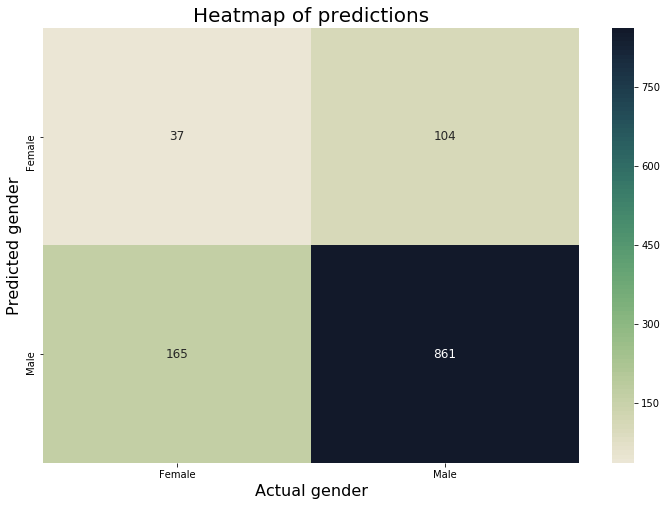

In [19]:
# Calculate the cluster labels
labels = best_rf.predict(X_test)
x_label = ['Female','Male']
y_label = ['Female','Male']

# Create a DataFrame with labels and species as columns
ct_df = pd.DataFrame({'predicts': labels, 'gender': y_test}).astype('int')

# Create crosstab
ct = pd.crosstab(ct_df.predicts,ct_df.gender).apply(lambda x: x, axis=1)
ct.index = x_label
ct.columns = y_label

# Display ct
print(ct)

# And display as a heatmap as an alternate way of understanding
_ = plt.figure(figsize=(12, 8))
_ = sns.heatmap(ct,annot=True,annot_kws={'size':12},
                cmap=sns.cubehelix_palette(100,start=360,rot=-.6,light=.9,dark=.1),
                xticklabels=x_label,yticklabels=y_label,fmt='g')
_ = plt.xlabel('Actual gender',fontsize=16)
_ = plt.ylabel('Predicted gender',fontsize=16) 
_ = plt.title('Heatmap of predictions',fontsize=20)

Now that the model is created, how does it do on the post-enactment period?

In [20]:
# Define data and target
A = mis_post_df[['bond_amount','days','age','offense_class','race']]
A = pd.get_dummies(A,columns=['offense_class','race'],drop_first=True)
b = mis_post_df.gender.ravel()

# Make y traditional binary so recall can be accessed
gender = {'M': 1,'F': 0}
b = [gender[item] for item in b]

scores(best_rf,A,b,cv=5)

Accuracy, gender (test): 0.8003 (+/- 0.02)
F1, gender (test): 0.86
Recall, gender (test): 0.88
Precision, gender (test): 0.84
AUROC, gender (test): 0.58


### It is possible to create a predictor that is 100% correct for gender if you include the facility.  CT only has one facility for housing both pretrial and sentenced women.  (Source: https://portal.ct.gov/DOC/Facility/York-CI)

This is not balanced or processed in any way.  It's just for representation.

Accuracy, gender (test): 1.0000 (+/- 0.00)
F1, gender (test): 1.00
Recall, gender (test): 1.00
Precision, gender (test): 1.00
AUROC, gender (test): 1.00


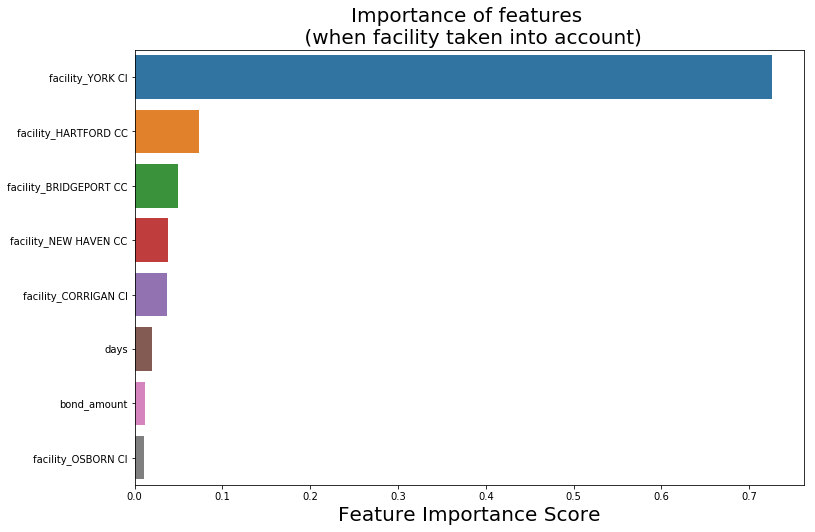

In [21]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race','facility']]
X = pd.get_dummies(X,columns=['offense_class','race','facility'],drop_first=True)
y = mis_pre_df.gender.ravel()

# Make y traditional binary so recall can be accessed
gender = {'M': 1,'F': 0}
y = [gender[item] for item in y]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

# Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=3)

clf.fit(X_train,y_train)

score = cross_val_score(clf, X_test, y_test, cv=5) 
print('Accuracy, gender (test): %0.4f (+/- %0.2f)' % (score.mean(), score.std() * 2))
print('F1, gender (test): %0.2f' % f1_score(y_test,clf.predict(X_test)))
print('Recall, gender (test): %0.2f' % recall_score(y_test,clf.predict(X_test)))
print('Precision, gender (test): %0.2f' % precision_score(y_test,clf.predict(X_test)))
print('AUROC, gender (test): %0.2f' % roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
# Restrict the features available on the y-axis so you can read them
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x=feature_imp[:8], y=feature_imp.index[:8])
_ = plt.xlabel('Feature Importance Score',fontsize=20)
_ = plt.title('Importance of features \n (when facility taken into account)',fontsize=20)